In [2]:
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from Data_Load_Assign import *
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)

# Set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

| using device: cuda


In [4]:
# Load Dataset
train_data, test_data = load_MNIST()

# print("Type of trainDataset：", type(train_data))
# print("Length of trainDataset：", len(train_data))

# print("Type of trainDataset[0]：", type(train_data[0]))
# print("Length of trainDataset[0]：", len(train_data[0]))

# print("Type of trainDataset[0][0]：", type(train_data[0][0]))
# print("Shape of trainDataset[0][0]：", train_data[0][0].shape)
# print("Type of trainDataset[0][1]：", type(train_data[0][1]))
# print("trainDataset[0][1]：", train_data[0][1])

# Get client dataloaders
iid_train_loader = iid_Assign(train_data)
noniid_train_loader = non_iid_Assign(train_data)
# print("iid_train_loader length", len(iid_train_loader))
# print("noniid_train_loader length", len(noniid_train_loader))

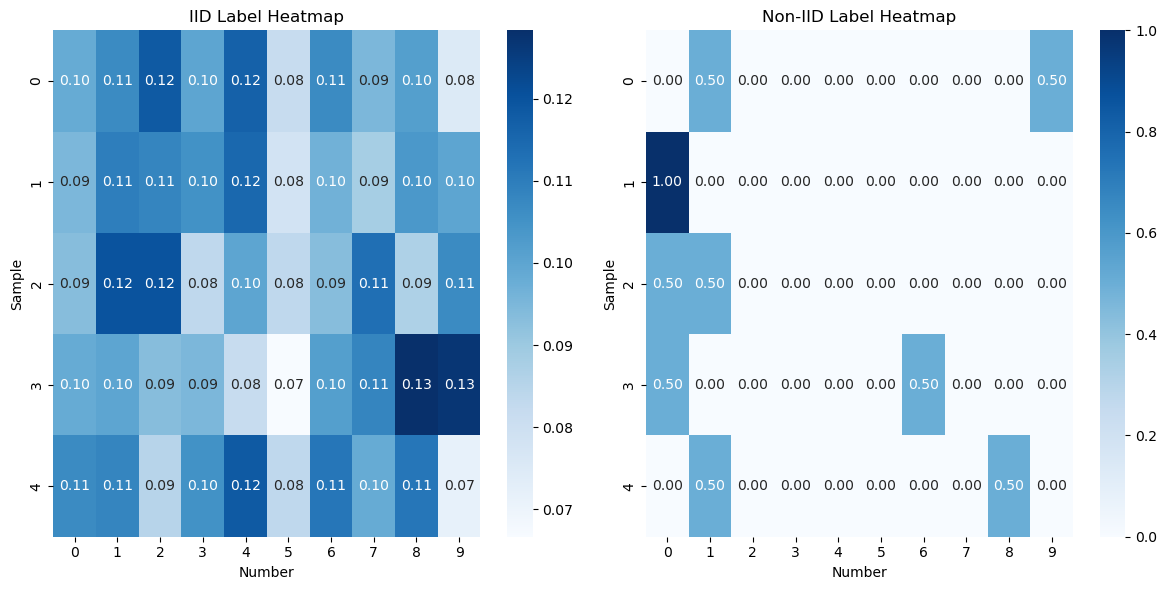

In [5]:
# Test iid and non-iid is correct.

# iid
sample_iid = random.sample(iid_train_loader, 5)
iid_labels = []
for i in sample_iid:
    iid_label = torch.zeros(10)
    for (x,y) in i:
        iid_label += torch.sum(F.one_hot(y, num_classes=10), dim=0)
    iid_labels.append(iid_label)
    
iid_labels = torch.stack(iid_labels)
iid_normalized = iid_labels / 600 # min-max normalization

# non_iid
sample_noniid = random.sample(noniid_train_loader, 5)
noniid_labels = []
for i in sample_noniid:
    noniid_label = torch.zeros(10)
    for (x,y) in i:
        noniid_label += torch.sum(F.one_hot(y, num_classes=10), dim=0)
    noniid_labels.append(noniid_label)
    
noniid_labels = torch.stack(noniid_labels)
noniid_normalized = noniid_labels / 600

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(iid_normalized.numpy(), cmap='Blues', annot=True, fmt=".2f", cbar=True)
plt.xlabel('Number')
plt.ylabel('Sample')
plt.title('IID Label Heatmap')

plt.subplot(1, 2, 2)
sns.heatmap(noniid_normalized.numpy(), cmap='Blues', annot=True, fmt=".2f", cbar=True)
plt.xlabel('Number')
plt.ylabel('Sample')
plt.title('Non-IID Label Heatmap')

plt.tight_layout()
plt.show()

In [41]:
# Model Defination

# Model 1: A simple multilayer-perceptron with 2-hidden
# layers with 200 units each using ReLu activations (199,210
# total parameters), which we refer to as the MNIST 2NN.

# define fully connected NN
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 200);
        self.fc2 = nn.Linear(200, 200);
        self.out = nn.Linear(200, 10);

    def forward(self, x):
        x = x.flatten(1) # torch.Size([B,784])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

print(MLP())
print("Total parameters of 2NN(MLP) is", num_params(MLP()))

# Model 2: A CNN with two 5x5 convolution layers (the first with
# 32 channels, the second with 64, each followed with 2x2
# max pooling), a fully connected layer with 512 units and
# ReLu activation, and a final softmax output layer (1,663,370
# total parameters).

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print("After x = F.relu(self.conv1(x)), the shape of x is: ", x.shape)
        x = self.pool1(x)
        # print("After x = self.pool1(x), the shape of x is: ", x.shape)
        x = F.relu(self.conv2(x))
        # print("After x = F.relu(self.conv2(x)), the shape of x is: ", x.shape)    
        x = self.pool2(x)
        # print("After x = self.pool1(F.relu(self.conv1(x))), the shape of x is: ", x.shape)
        
        x = x.view(-1, 64 * 7 * 7) # flatten
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

print(CNN())
print("Total parameters of CNN is", num_params(CNN()))

# Q: The paper said there will be 1,663,370 total parameters. Something wrong?

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
Total parameters of 2NN(MLP) is 199210
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Total parameters of CNN is 1663370


In [42]:
# Fed_Avg
def fedavg(global_model, C, K, E, c_loader, rounds, lr, acc_threshold):
    # C is the fraction of clients that perform computation on each round.
    assert C <= 1 and C >= 0
    # K is the number of clients.
    # E is the local epochs, the number of training passes each client makes
    # over its local dataset on each round.
    
    c_per_round = max( round(C * K), 1)
    accuracy = []
    
    for rd in range(rounds):
        
        # Choose c_per_round clients
        clients = random.sample(range(K), c_per_round)
        
        # Train on clients one by one
        client_model = []
        for i, c in enumerate(clients):
            local_model = client_training(global_model, id = c, local_epochs = E, dataloader = c_loader[c], lr = lr)
            local_model = local_model.to(device)
            client_model.append(local_model.state_dict())
            # print("round{}, client{} finished. {}/{}".format(rd, c, i+1, c_per_round))
            
    
        # Average and iterate global model parameters for next round  
        keys = client_model[0].keys()
        next_global_dict = {key: 0 for key in keys}
        for key in keys:
            values = [d[key] for d in client_model]
            averaged_value = sum(values) / len(values)
            next_global_dict[key] = averaged_value
            
        global_model.load_state_dict(next_global_dict)
        global_model = global_model.to(device)
        
        # Validate accuracy this round
        test_inputs, test_labels = zip(*test_data)
        # print("Type of test_inputs：", type(test_inputs))
        # print("Length of test_inputs：", len(test_inputs))
        # print("Type of test_inputs[0]：", type(test_inputs[0]))
        # print("Size of test_inputs[0]：", test_inputs[0].size())
        
        # print("Type of test_labels：", type(test_labels))
        # print("Length of test_labels：", len(test_labels))
        # print("Type of test_labels[0]：", type(test_labels[0]))
        test_inputs = torch.stack(test_inputs).to(device)
        test_labels = torch.Tensor(test_labels).to(device)

        global_model.eval()
        with torch.no_grad():
            predictions = global_model(test_inputs)

        predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
        true_labels = test_labels.cpu().numpy()

        acc = accuracy_score(true_labels, predicted_labels)
        if rd%10 == 0 or acc >= acc_threshold:
            print("The clients in round {} are: {}".format(rd, clients))
            print("Accuracy of round {}:{}".format(rd, acc))
            print()
        accuracy.append(acc)
        if acc >= acc_threshold:
            break
        
    return accuracy

In [43]:
criterion = nn.CrossEntropyLoss()

def client_training(global_model, id, local_epochs, dataloader, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)
    
    for epoch in range(local_epochs):
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = local_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
    return local_model

# MNIST 2NN 

In [8]:
mlp = MLP()
acc_threshold_2nn = 0.97

The clients in round 0 are: [85, 22, 1, 60, 87, 52, 72, 65, 39, 83]
Accuracy of round 0:0.5578

The clients in round 10 are: [27, 1, 91, 96, 0, 86, 67, 78, 12, 24]
Accuracy of round 10:0.9047

The clients in round 20 are: [38, 53, 13, 12, 71, 61, 60, 43, 15, 14]
Accuracy of round 20:0.9303

The clients in round 30 are: [43, 90, 95, 40, 41, 4, 67, 18, 32, 77]
Accuracy of round 30:0.9422

The clients in round 40 are: [49, 58, 6, 12, 60, 99, 19, 2, 4, 76]
Accuracy of round 40:0.9517

The clients in round 50 are: [9, 76, 18, 26, 0, 84, 86, 93, 15, 95]
Accuracy of round 50:0.9569

The clients in round 60 are: [77, 88, 19, 89, 57, 51, 23, 98, 53, 55]
Accuracy of round 60:0.9606

The clients in round 70 are: [51, 94, 99, 35, 37, 56, 47, 72, 80, 17]
Accuracy of round 70:0.9652

The clients in round 80 are: [75, 90, 6, 49, 4, 29, 81, 10, 23, 46]
Accuracy of round 80:0.9673

The clients in round 90 are: [9, 1, 58, 63, 92, 56, 6, 52, 15, 10]
Accuracy of round 90:0.9686

The clients in round 93 ar

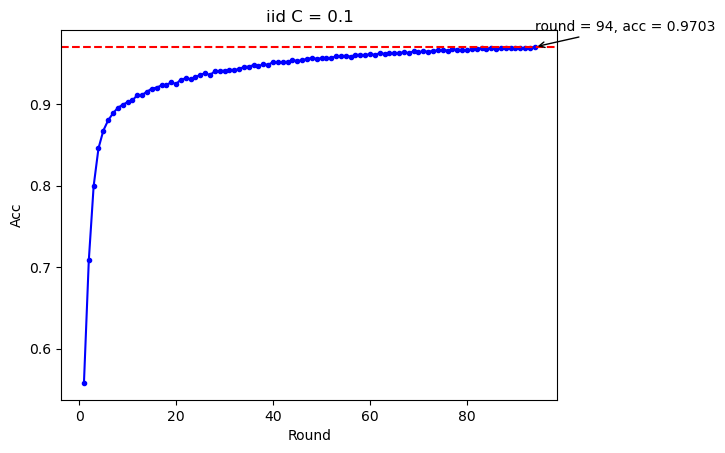

94 rounds needed to achieve the accuracy of 0.9703


In [9]:
# iid C = 0.1
mlp_iid1 = copy.deepcopy(mlp)
acc_mlp_iid1 = fedavg(mlp_iid1, C = 0.1, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_iid1, acc_threshold_2nn, 'iid C = 0.1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid1), acc_mlp_iid1[-1]))

The clients in round 0 are: [91, 37, 99, 56, 65, 77, 59, 68, 81, 33, 34, 29, 2, 15, 78, 12, 22, 93, 53, 31]
Accuracy of round 0:0.6377

The clients in round 10 are: [2, 21, 95, 87, 71, 91, 10, 54, 76, 13, 79, 80, 58, 90, 19, 78, 77, 5, 32, 43]
Accuracy of round 10:0.91

The clients in round 20 are: [12, 24, 21, 56, 8, 54, 81, 50, 34, 32, 55, 96, 99, 45, 78, 41, 11, 39, 3, 63]
Accuracy of round 20:0.9305

The clients in round 30 are: [60, 10, 6, 68, 51, 33, 3, 82, 66, 12, 42, 45, 4, 19, 80, 36, 0, 48, 43, 20]
Accuracy of round 30:0.9411

The clients in round 40 are: [17, 63, 45, 79, 94, 36, 91, 42, 87, 15, 52, 98, 33, 20, 43, 80, 64, 68, 88, 18]
Accuracy of round 40:0.9523

The clients in round 50 are: [80, 45, 55, 35, 51, 98, 91, 36, 13, 61, 37, 15, 57, 19, 44, 31, 95, 23, 43, 63]
Accuracy of round 50:0.9581

The clients in round 60 are: [79, 63, 84, 73, 27, 76, 56, 4, 31, 62, 77, 40, 71, 93, 25, 0, 5, 7, 17, 86]
Accuracy of round 60:0.961

The clients in round 70 are: [71, 85, 99, 98,

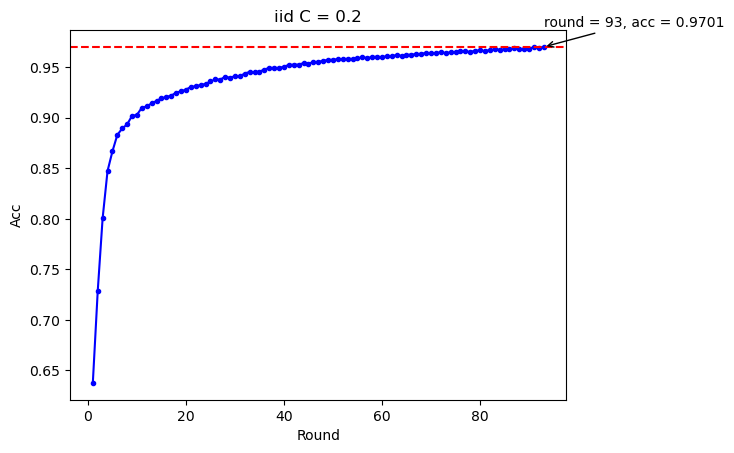

93 rounds needed to achieve the accuracy of 0.9701


In [10]:
# iid C = 0.2
mlp_iid2 = copy.deepcopy(mlp)
acc_mlp_iid2 = fedavg(mlp_iid2, C = 0.2, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_iid2, acc_threshold_2nn, 'iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid2), acc_mlp_iid2[-1]))

The clients in round 0 are: [12, 56, 83, 81, 34, 30, 82, 33, 39, 10, 47, 18, 57, 3, 49, 93, 87, 6, 80, 36, 65, 54, 59, 72, 66, 24, 20, 0, 95, 13, 85, 32, 25, 62, 60, 92, 51, 8, 38, 31, 17, 55, 11, 44, 76, 70, 21, 16, 45, 63]
Accuracy of round 0:0.6135

The clients in round 10 are: [32, 47, 67, 81, 14, 21, 63, 25, 72, 78, 75, 9, 52, 36, 5, 33, 0, 3, 77, 20, 42, 22, 51, 29, 74, 70, 92, 4, 69, 24, 58, 57, 79, 44, 46, 95, 2, 26, 23, 11, 30, 55, 68, 64, 65, 43, 71, 40, 96, 98]
Accuracy of round 10:0.9078

The clients in round 20 are: [45, 46, 12, 97, 48, 62, 16, 42, 73, 66, 26, 77, 28, 76, 72, 56, 88, 36, 96, 17, 53, 81, 24, 93, 22, 34, 35, 41, 21, 57, 43, 78, 11, 50, 1, 7, 83, 71, 27, 84, 15, 51, 94, 61, 37, 64, 70, 4, 30, 38]
Accuracy of round 20:0.9292

The clients in round 30 are: [42, 19, 13, 65, 40, 77, 31, 97, 71, 92, 87, 61, 66, 78, 63, 36, 99, 86, 11, 26, 5, 51, 33, 96, 43, 28, 75, 94, 8, 57, 16, 4, 12, 56, 35, 83, 32, 74, 1, 21, 46, 20, 95, 15, 52, 22, 59, 23, 54, 45]
Accuracy of 

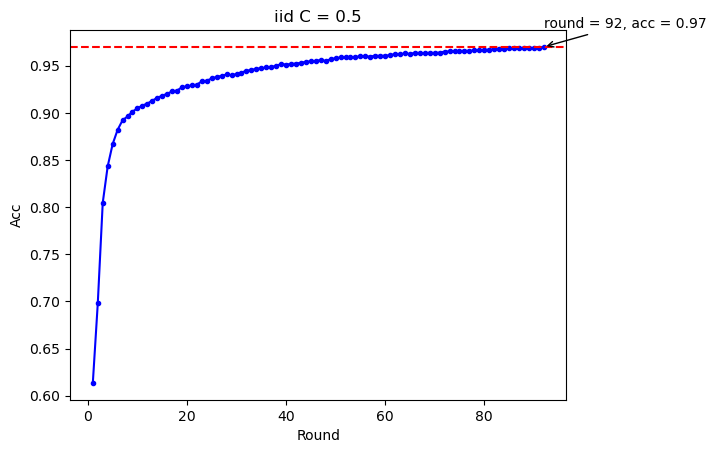

92 rounds needed to achieve the accuracy of 0.97


In [12]:
# iid C = 0.5
mlp_iid3 = copy.deepcopy(mlp)
acc_mlp_iid3 = fedavg(mlp_iid3, C = 0.5, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_iid3, acc_threshold_2nn, 'iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid3), acc_mlp_iid3[-1]))

The clients in round 0 are: [25, 1, 96, 77, 86, 65, 39, 12, 52, 46, 48, 90, 97, 89, 26, 40, 98, 7, 13, 79, 64, 53, 14, 78, 43, 28, 75, 42, 44, 47, 18, 84, 73, 10, 32, 67, 35, 68, 69, 56, 9, 85, 37, 99, 87, 38, 6, 55, 17, 74, 62, 8, 61, 95, 51, 3, 0, 15, 23, 21, 82, 50, 71, 45, 59, 31, 81, 91, 49, 2, 57, 88, 72, 94, 63, 33, 41, 11, 70, 36, 5, 30, 29, 4, 92, 16, 83, 54, 60, 58, 27, 34, 93, 20, 24, 22, 66, 19, 76, 80]
Accuracy of round 0:0.6215

The clients in round 10 are: [60, 81, 23, 5, 79, 67, 34, 37, 64, 12, 2, 62, 35, 54, 96, 32, 61, 85, 69, 99, 83, 74, 94, 43, 80, 86, 98, 87, 4, 9, 11, 29, 24, 27, 72, 40, 22, 93, 25, 14, 15, 84, 82, 1, 48, 97, 0, 73, 19, 95, 30, 3, 70, 42, 44, 78, 38, 7, 51, 47, 77, 26, 31, 49, 20, 10, 59, 63, 65, 41, 57, 18, 13, 45, 90, 88, 39, 17, 66, 71, 75, 89, 91, 50, 6, 53, 52, 8, 46, 55, 92, 36, 16, 33, 28, 58, 21, 76, 68, 56]
Accuracy of round 10:0.908

The clients in round 20 are: [97, 13, 89, 91, 73, 48, 26, 68, 47, 93, 19, 58, 8, 69, 94, 15, 64, 23, 66, 

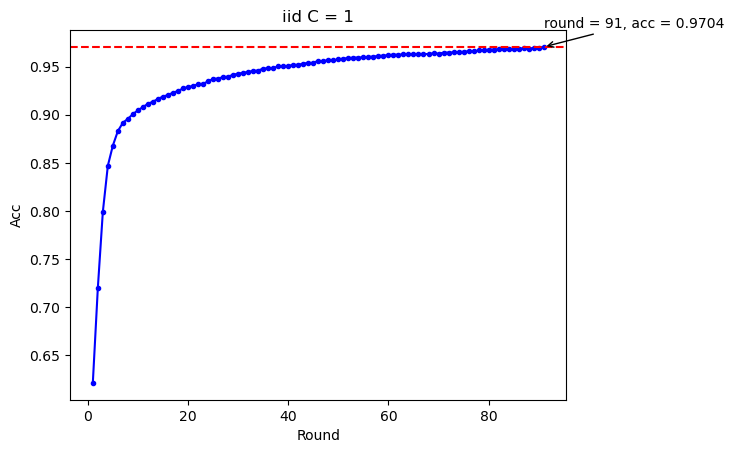

91 rounds needed to achieve the accuracy of 0.9704


In [13]:
# iid C = 1
mlp_iid4 = copy.deepcopy(mlp)
acc_mlp_iid4 = fedavg(mlp_iid4, C = 1, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_iid4, acc_threshold_2nn, 'iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid4), acc_mlp_iid4[-1]))

The clients in round 0 are: [2, 15, 6, 33, 44, 66, 77, 85, 47, 32]
Accuracy of round 0:0.1028

The clients in round 10 are: [22, 12, 33, 14, 4, 17, 32, 72, 94, 71]
Accuracy of round 10:0.5834

The clients in round 20 are: [35, 37, 88, 64, 4, 59, 22, 47, 11, 95]
Accuracy of round 20:0.7206

The clients in round 30 are: [11, 24, 68, 7, 40, 10, 12, 41, 81, 45]
Accuracy of round 30:0.7713

The clients in round 40 are: [13, 19, 80, 11, 39, 38, 66, 55, 59, 72]
Accuracy of round 40:0.8531

The clients in round 50 are: [11, 94, 41, 70, 68, 43, 49, 53, 75, 58]
Accuracy of round 50:0.8704

The clients in round 60 are: [66, 72, 69, 82, 81, 20, 79, 26, 22, 35]
Accuracy of round 60:0.8633

The clients in round 70 are: [31, 39, 14, 9, 47, 51, 67, 6, 44, 29]
Accuracy of round 70:0.8997

The clients in round 80 are: [54, 71, 25, 58, 88, 78, 52, 24, 47, 40]
Accuracy of round 80:0.8805

The clients in round 90 are: [9, 83, 77, 48, 68, 1, 24, 41, 21, 89]
Accuracy of round 90:0.8889

The clients in round 

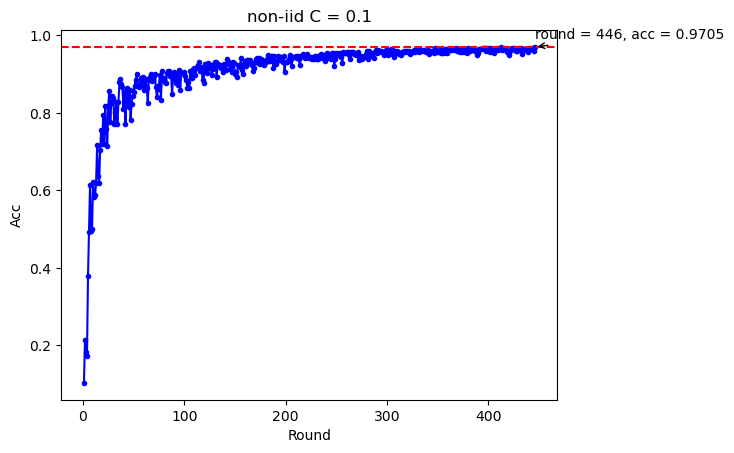

446 rounds needed to achieve the accuracy of 0.9705


In [14]:
# non-iid C = 0.1
mlp_noniid1 = copy.deepcopy(mlp)
acc_mlp_noniid1 = fedavg(mlp_noniid1, C = 0.1, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_noniid1, acc_threshold_2nn, 'non-iid C = 0.1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid1), acc_mlp_noniid1[-1]))

The clients in round 0 are: [5, 59, 64, 28, 11, 12, 62, 96, 99, 77, 82, 43, 61, 88, 50, 66, 16, 29, 58, 48]
Accuracy of round 0:0.2062

The clients in round 10 are: [66, 73, 35, 99, 17, 61, 18, 65, 12, 22, 21, 70, 75, 2, 44, 28, 33, 85, 80, 54]
Accuracy of round 10:0.7529

The clients in round 20 are: [2, 19, 91, 81, 38, 14, 22, 64, 68, 45, 36, 72, 42, 95, 51, 87, 59, 24, 69, 0]
Accuracy of round 20:0.8255

The clients in round 30 are: [41, 94, 73, 17, 40, 95, 54, 4, 30, 52, 20, 87, 49, 99, 85, 29, 28, 65, 2, 62]
Accuracy of round 30:0.8372

The clients in round 40 are: [14, 82, 32, 6, 17, 74, 81, 78, 47, 95, 33, 20, 8, 50, 92, 25, 38, 62, 2, 65]
Accuracy of round 40:0.8848

The clients in round 50 are: [0, 5, 35, 7, 79, 2, 22, 72, 1, 74, 62, 69, 37, 97, 80, 67, 88, 4, 3, 12]
Accuracy of round 50:0.899

The clients in round 60 are: [64, 46, 24, 76, 31, 73, 70, 66, 10, 79, 12, 14, 77, 37, 23, 91, 86, 49, 0, 27]
Accuracy of round 60:0.897

The clients in round 70 are: [54, 67, 39, 55, 11

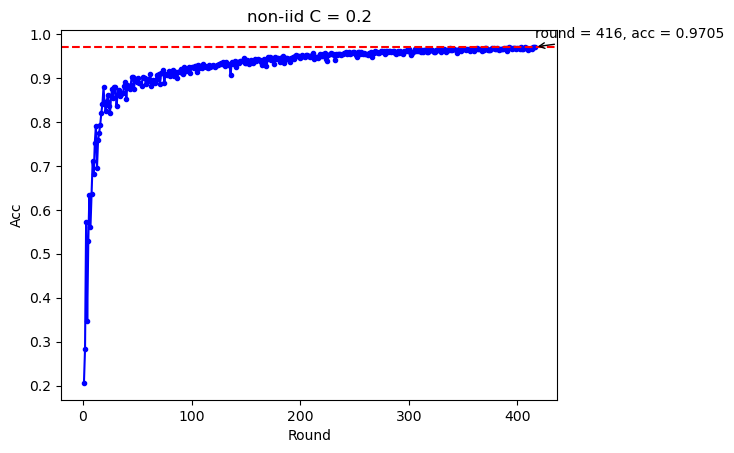

416 rounds needed to achieve the accuracy of 0.9705


In [15]:
# non-iid C = 0.2
mlp_noniid2 = copy.deepcopy(mlp)
acc_mlp_noniid2 = fedavg(mlp_noniid2, C = 0.2, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_noniid2, acc_threshold_2nn, 'non-iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid2), acc_mlp_noniid2[-1]))

The clients in round 0 are: [91, 47, 2, 27, 57, 61, 92, 19, 49, 46, 39, 36, 78, 45, 97, 23, 30, 76, 10, 98, 54, 13, 88, 17, 82, 20, 25, 0, 34, 9, 5, 84, 58, 77, 71, 50, 80, 95, 4, 42, 8, 12, 3, 81, 51, 67, 53, 41, 70, 85]
Accuracy of round 0:0.26

The clients in round 10 are: [14, 25, 78, 75, 41, 46, 22, 64, 44, 74, 83, 77, 38, 39, 79, 17, 90, 62, 4, 2, 72, 94, 30, 58, 33, 89, 47, 95, 5, 51, 70, 96, 8, 15, 71, 0, 7, 97, 10, 98, 11, 3, 73, 88, 31, 27, 69, 66, 21, 60]
Accuracy of round 10:0.7856

The clients in round 20 are: [58, 90, 53, 0, 48, 70, 30, 42, 1, 37, 64, 52, 17, 19, 12, 94, 81, 3, 32, 40, 38, 78, 2, 63, 26, 67, 22, 62, 9, 61, 5, 80, 23, 71, 75, 49, 96, 21, 31, 25, 83, 27, 73, 16, 60, 59, 65, 7, 57, 91]
Accuracy of round 20:0.8756

The clients in round 30 are: [55, 60, 69, 66, 28, 73, 22, 31, 50, 36, 8, 40, 94, 0, 39, 46, 9, 64, 85, 71, 20, 86, 7, 83, 78, 33, 27, 57, 19, 21, 49, 1, 58, 74, 14, 47, 6, 51, 77, 67, 91, 35, 75, 16, 24, 65, 76, 56, 82, 61]
Accuracy of round 30:0.8

The clients in round 330 are: [9, 60, 36, 67, 48, 80, 97, 85, 94, 79, 26, 19, 8, 21, 91, 93, 40, 98, 74, 44, 23, 0, 83, 7, 58, 53, 87, 84, 92, 50, 49, 99, 25, 20, 82, 15, 62, 13, 73, 3, 71, 11, 34, 27, 16, 76, 70, 56, 72, 47]
Accuracy of round 330:0.9662

The clients in round 340 are: [12, 40, 71, 3, 44, 1, 47, 69, 7, 25, 8, 95, 75, 42, 20, 53, 45, 49, 35, 66, 26, 46, 93, 83, 13, 30, 55, 81, 43, 99, 29, 84, 96, 59, 76, 39, 72, 68, 63, 50, 31, 21, 11, 19, 18, 14, 91, 80, 64, 51]
Accuracy of round 340:0.9677

The clients in round 350 are: [37, 20, 50, 2, 29, 71, 31, 90, 27, 42, 13, 30, 73, 53, 24, 54, 17, 48, 10, 74, 58, 67, 75, 84, 88, 95, 56, 44, 68, 70, 8, 77, 36, 18, 60, 23, 43, 1, 12, 92, 72, 28, 69, 32, 87, 64, 80, 11, 59, 98]
Accuracy of round 350:0.9667

The clients in round 360 are: [61, 76, 57, 79, 22, 49, 60, 58, 53, 48, 25, 67, 45, 86, 94, 95, 63, 34, 93, 72, 85, 42, 1, 78, 5, 64, 73, 62, 88, 75, 87, 31, 97, 15, 55, 8, 59, 43, 35, 39, 10, 26, 24, 51, 50, 68, 98, 47, 46, 2]
Ac

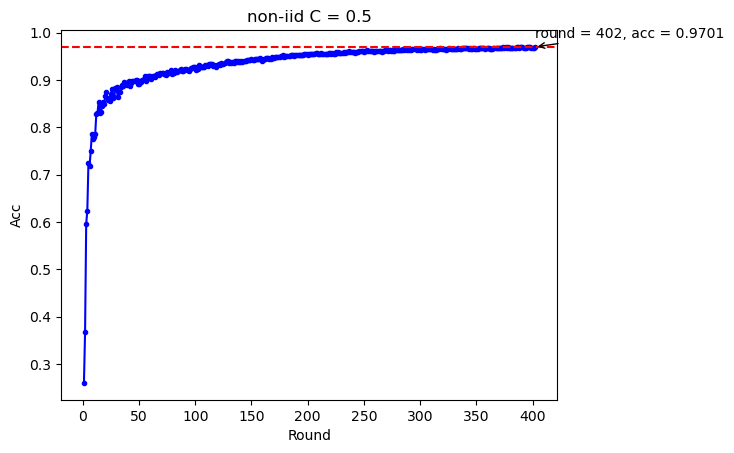

402 rounds needed to achieve the accuracy of 0.9701


In [16]:
# non-iid C = 0.5
mlp_noniid3 = copy.deepcopy(mlp)
acc_mlp_noniid3 = fedavg(mlp_noniid3, C = 0.5, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_noniid3, acc_threshold_2nn, 'non-iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid3), acc_mlp_noniid3[-1]))

The clients in round 0 are: [86, 75, 4, 17, 9, 21, 39, 8, 20, 22, 61, 31, 85, 90, 7, 83, 25, 96, 70, 56, 92, 23, 26, 82, 50, 59, 77, 5, 53, 28, 32, 88, 47, 24, 97, 19, 41, 11, 69, 3, 34, 54, 40, 94, 0, 35, 95, 16, 10, 42, 30, 80, 58, 91, 45, 15, 37, 12, 27, 43, 65, 76, 18, 36, 73, 1, 57, 38, 67, 63, 33, 98, 89, 81, 48, 51, 64, 29, 60, 46, 79, 2, 71, 52, 74, 62, 6, 44, 78, 84, 93, 72, 99, 13, 55, 87, 14, 66, 68, 49]
Accuracy of round 0:0.3611

The clients in round 10 are: [59, 70, 1, 6, 81, 97, 42, 17, 11, 39, 48, 24, 0, 41, 10, 65, 45, 86, 8, 16, 50, 57, 90, 84, 54, 26, 92, 18, 71, 23, 22, 13, 95, 94, 28, 37, 15, 14, 49, 32, 47, 93, 69, 67, 3, 61, 43, 2, 4, 25, 68, 56, 75, 33, 40, 73, 99, 88, 60, 35, 53, 9, 74, 72, 83, 76, 52, 38, 66, 89, 80, 79, 78, 12, 63, 55, 51, 44, 7, 21, 20, 27, 64, 62, 98, 85, 30, 34, 96, 19, 5, 91, 46, 77, 87, 58, 31, 29, 82, 36]
Accuracy of round 10:0.8254

The clients in round 20 are: [63, 61, 28, 9, 6, 5, 90, 95, 96, 89, 54, 56, 10, 41, 94, 59, 50, 46, 22, 4

The clients in round 190 are: [18, 68, 29, 30, 24, 56, 90, 66, 28, 97, 92, 51, 64, 85, 91, 95, 35, 42, 40, 74, 99, 82, 81, 77, 65, 59, 17, 8, 41, 13, 21, 67, 15, 87, 22, 23, 39, 20, 0, 86, 47, 52, 54, 78, 71, 73, 60, 46, 5, 16, 45, 7, 84, 32, 36, 49, 53, 72, 4, 48, 38, 12, 44, 14, 76, 98, 33, 26, 57, 69, 50, 31, 62, 27, 61, 79, 89, 55, 6, 58, 93, 25, 9, 96, 1, 37, 80, 11, 34, 75, 3, 88, 70, 2, 94, 63, 10, 19, 43, 83]
Accuracy of round 190:0.9543

The clients in round 200 are: [17, 89, 63, 82, 31, 32, 0, 4, 66, 23, 41, 44, 10, 35, 5, 92, 91, 18, 38, 20, 74, 94, 36, 9, 28, 55, 80, 83, 6, 59, 95, 19, 42, 75, 67, 25, 72, 2, 12, 99, 3, 69, 39, 21, 46, 61, 15, 65, 22, 47, 45, 78, 58, 64, 50, 14, 24, 48, 11, 90, 76, 54, 60, 43, 49, 93, 52, 77, 98, 16, 86, 73, 70, 97, 87, 29, 8, 56, 40, 1, 34, 88, 84, 51, 68, 96, 53, 57, 79, 27, 13, 71, 7, 81, 33, 85, 30, 62, 26, 37]
Accuracy of round 200:0.9563

The clients in round 210 are: [94, 6, 88, 8, 31, 87, 38, 28, 24, 44, 15, 98, 34, 0, 67, 42, 99, 1,

The clients in round 380 are: [59, 27, 63, 20, 99, 81, 52, 37, 47, 43, 31, 3, 64, 44, 78, 9, 75, 29, 56, 8, 30, 98, 15, 72, 82, 90, 92, 34, 0, 88, 49, 61, 62, 12, 26, 79, 51, 41, 57, 7, 45, 48, 67, 13, 1, 38, 19, 28, 65, 24, 25, 17, 77, 18, 66, 35, 93, 11, 10, 68, 6, 40, 80, 14, 42, 4, 96, 89, 73, 46, 71, 70, 97, 84, 87, 16, 83, 54, 58, 2, 23, 85, 76, 39, 69, 22, 95, 60, 74, 36, 33, 5, 50, 21, 55, 53, 86, 94, 91, 32]
Accuracy of round 380:0.9687

The clients in round 390 are: [0, 33, 84, 11, 83, 2, 72, 46, 94, 90, 29, 9, 34, 59, 95, 38, 37, 61, 98, 96, 82, 10, 77, 67, 54, 23, 78, 51, 14, 20, 52, 80, 91, 71, 32, 69, 19, 16, 99, 86, 3, 18, 5, 56, 65, 21, 41, 27, 1, 40, 81, 42, 30, 22, 6, 85, 97, 68, 4, 57, 55, 53, 93, 79, 28, 47, 15, 74, 12, 89, 63, 8, 70, 35, 43, 31, 75, 58, 45, 39, 17, 24, 92, 87, 13, 60, 66, 76, 25, 62, 64, 26, 49, 48, 44, 7, 36, 88, 50, 73]
Accuracy of round 390:0.9696

The clients in round 395 are: [92, 93, 22, 47, 56, 42, 74, 64, 1, 82, 28, 96, 90, 91, 49, 63, 66, 

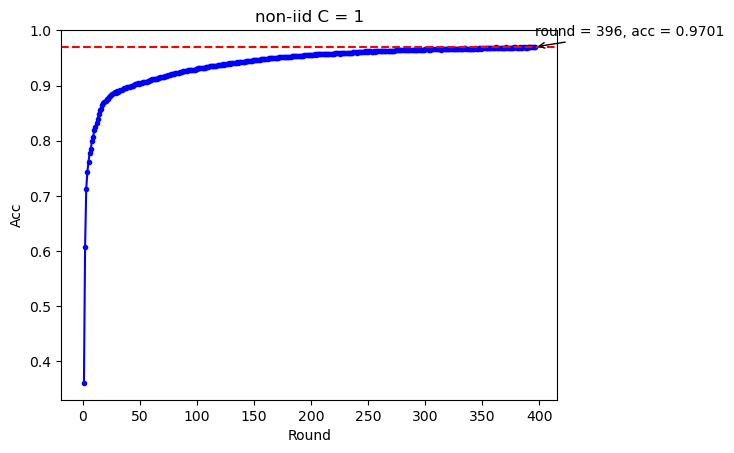

396 rounds needed to achieve the accuracy of 0.9701


In [17]:
# non-iid C = 1
mlp_noniid4 = copy.deepcopy(mlp)
acc_mlp_noniid4 = fedavg(mlp_noniid4, C = 1, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_noniid4, acc_threshold_2nn, 'non-iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid4), acc_mlp_noniid4[-1]))

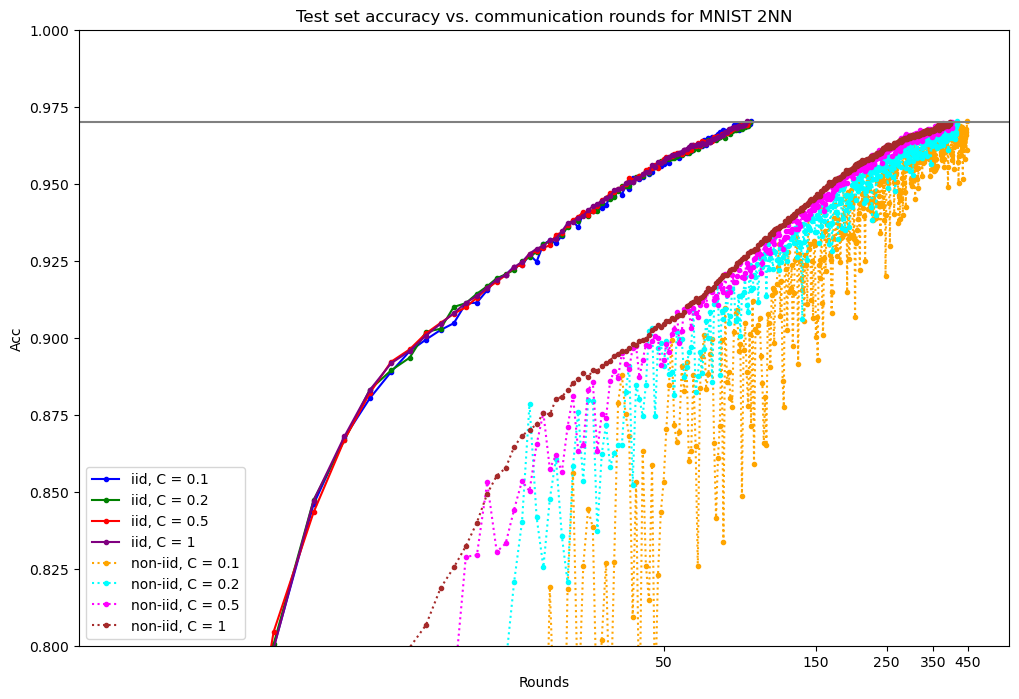

In [23]:
plt.figure(figsize=(12, 8))
log_rounds = np.log10(range(50, 500, 100))
rounds = range(50, 500, 100) 

plt.plot(np.log10(range(1, len(acc_mlp_iid1) + 1)), acc_mlp_iid1, marker='.', linestyle='solid', color='blue', label='iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_mlp_iid2) + 1)), acc_mlp_iid2, marker='.', linestyle='solid', color='green', label='iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_mlp_iid3) + 1)), acc_mlp_iid3, marker='.', linestyle='solid', color='red', label='iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_mlp_iid4) + 1)), acc_mlp_iid4, marker='.', linestyle='solid', color='purple', label='iid, C = 1')
plt.plot(np.log10(range(1, len(acc_mlp_noniid1) + 1)), acc_mlp_noniid1, marker='.', linestyle='dotted', color='orange', label='non-iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_mlp_noniid2) + 1)), acc_mlp_noniid2, marker='.', linestyle='dotted', color='cyan', label='non-iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_mlp_noniid3) + 1)), acc_mlp_noniid3, marker='.', linestyle='dotted', color='magenta', label='non-iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_mlp_noniid4) + 1)), acc_mlp_noniid4, marker='.', linestyle='dotted', color='brown', label='non-iid, C = 1')

plt.axhline(y=acc_threshold_2nn, color='gray', linestyle='solid')

plt.xlabel('Rounds')
plt.ylabel('Acc')

plt.title('Test set accuracy vs. communication rounds for MNIST 2NN')

plt.ylim(0.8, 1)
plt.xticks(log_rounds, rounds)

plt.legend()

plt.show()

# MNIST CNN

In [44]:
cnn = CNN()
acc_threshold_cnn = 0.99

The clients in round 0 are: [19, 83, 58, 47, 64, 48, 67, 4, 73, 11]
Accuracy of round 0:0.2059

The clients in round 10 are: [83, 15, 87, 91, 79, 37, 16, 49, 95, 66]
Accuracy of round 10:0.9607

The clients in round 20 are: [60, 37, 70, 81, 41, 23, 75, 10, 13, 68]
Accuracy of round 20:0.9754

The clients in round 30 are: [0, 27, 38, 14, 98, 80, 69, 77, 19, 54]
Accuracy of round 30:0.9791

The clients in round 40 are: [64, 40, 63, 83, 7, 56, 38, 18, 95, 6]
Accuracy of round 40:0.9814

The clients in round 50 are: [66, 85, 83, 70, 94, 55, 74, 58, 62, 32]
Accuracy of round 50:0.9846

The clients in round 60 are: [35, 45, 40, 55, 13, 71, 36, 78, 69, 25]
Accuracy of round 60:0.9849

The clients in round 70 are: [77, 75, 16, 80, 63, 13, 78, 3, 67, 76]
Accuracy of round 70:0.9859

The clients in round 80 are: [5, 72, 15, 52, 49, 21, 0, 64, 17, 79]
Accuracy of round 80:0.9868

The clients in round 90 are: [49, 32, 26, 14, 72, 42, 31, 75, 86, 92]
Accuracy of round 90:0.9885

The clients in roun

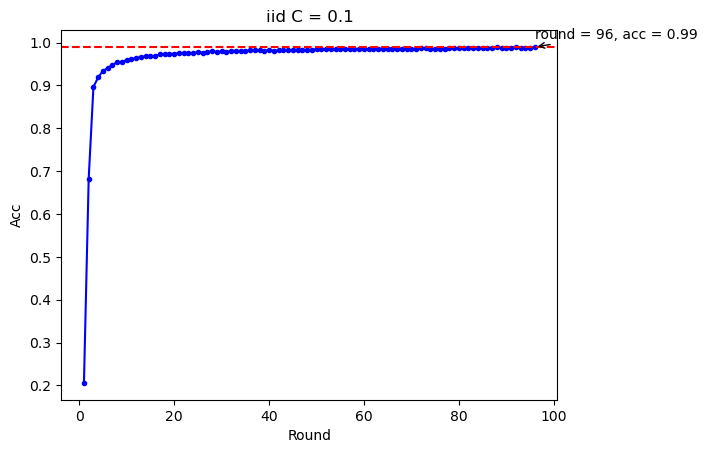

96 rounds needed to achieve the accuracy of 0.99


In [45]:
# iid C = 0.1
cnn_iid1 = copy.deepcopy(cnn)
acc_cnn_iid1 = fedavg(cnn_iid1, C = 0.1, K = 100, E = 5, 
                      c_loader = iid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_iid1, acc_threshold_cnn, 'iid C = 0.1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_iid1), acc_cnn_iid1[-1]))

The clients in round 0 are: [74, 14, 64, 80, 69, 77, 49, 96, 55, 34, 39, 36, 1, 54, 99, 91, 35, 33, 68, 67]
Accuracy of round 0:0.2073

The clients in round 10 are: [69, 10, 66, 43, 0, 99, 13, 54, 77, 45, 72, 57, 42, 48, 65, 46, 81, 15, 17, 40]
Accuracy of round 10:0.963

The clients in round 20 are: [50, 3, 98, 53, 93, 55, 13, 91, 58, 77, 59, 20, 21, 43, 60, 52, 75, 36, 97, 64]
Accuracy of round 20:0.9756

The clients in round 30 are: [20, 38, 77, 18, 58, 8, 61, 50, 72, 52, 71, 11, 33, 29, 14, 37, 46, 12, 17, 84]
Accuracy of round 30:0.9809

The clients in round 40 are: [58, 70, 43, 16, 53, 32, 48, 10, 72, 64, 42, 29, 31, 44, 61, 99, 52, 3, 57, 92]
Accuracy of round 40:0.9828

The clients in round 50 are: [67, 61, 55, 40, 49, 93, 3, 14, 77, 85, 17, 97, 18, 15, 90, 31, 4, 80, 34, 33]
Accuracy of round 50:0.9848

The clients in round 60 are: [90, 20, 31, 97, 71, 16, 74, 87, 21, 95, 67, 99, 38, 94, 2, 92, 58, 25, 7, 52]
Accuracy of round 60:0.9859

The clients in round 70 are: [7, 43, 17

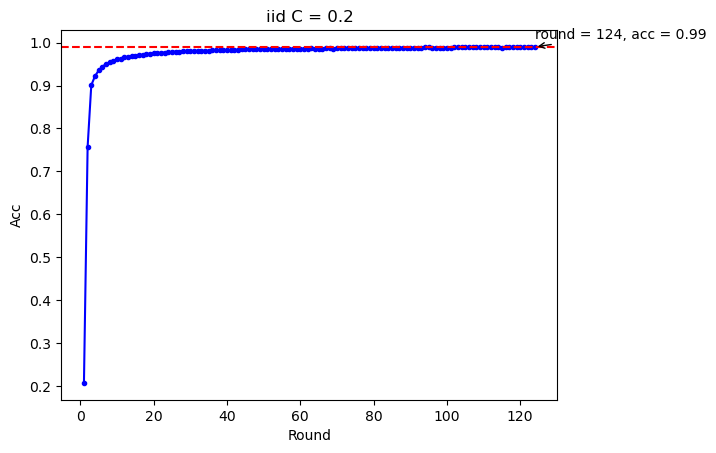

124 rounds needed to achieve the accuracy of 0.99


In [46]:
# iid C = 0.2
cnn_iid2 = copy.deepcopy(cnn)
acc_cnn_iid2 = fedavg(cnn_iid2, C = 0.2, K = 100, E = 5, 
                      c_loader = iid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_iid2, acc_threshold_cnn, 'iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_iid2), acc_cnn_iid2[-1]))

In [ ]:
# iid C = 0.5
cnn_iid3 = copy.deepcopy(cnn)
acc_cnn_iid3 = fedavg(cnn_iid3, C = 0.5, K = 100, E = 5, 
                      c_loader = iid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_iid3, acc_threshold_cnn, 'iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_iid3), acc_cnn_iid3[-1]))

In [ ]:
# iid C = 1
cnn_iid4 = copy.deepcopy(cnn)
acc_cnn_iid4 = fedavg(cnn_iid4, C = 1, K = 100, E = 5, 
                      c_loader = iid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_iid4, acc_threshold_cnn, 'iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_iid4), acc_cnn_iid4[-1]))

In [ ]:
# non-iid C = 0.1
cnn_noniid1 = copy.deepcopy(cnn)
acc_cnn_noniid1 = fedavg(cnn_noniid1, C = 0.1, K = 100, E = 5, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_noniid1, acc_threshold_cnn, 'non-iid C = 0.1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_noniid1), acc_cnn_noniid1[-1]))

In [ ]:
# non-iid C = 0.2
cnn_noniid2 = copy.deepcopy(cnn)
acc_cnn_noniid2 = fedavg(cnn_noniid2, C = 0.2, K = 100, E = 5, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_noniid2, acc_threshold_cnn, 'non-iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_noniid2), acc_cnn_noniid2[-1]))

In [ ]:
# non-iid C = 0.5
cnn_noniid3 = copy.deepcopy(cnn)
acc_cnn_noniid3 = fedavg(cnn_noniid3, C = 0.5, K = 100, E = 5, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_noniid3, acc_threshold_cnn, 'non-iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_noniid3), acc_cnn_noniid3[-1]))

In [ ]:
# non-iid C = 1
cnn_noniid4 = copy.deepcopy(cnn)
acc_cnn_noniid4 = fedavg(cnn_noniid4, C = 1, K = 100, E = 5, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_noniid4, acc_threshold_cnn, 'non-iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_noniid4), acc_cnn_noniid4[-1]))

In [ ]:
plt.figure(figsize=(12, 8))
log_rounds = np.log10(range(50, 500, 100))
rounds = range(50, 500, 100) 

plt.plot(np.log10(range(1, len(acc_cnn_iid1) + 1)), acc_cnn_iid1, marker='.', linestyle='solid', color='blue', label='iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_cnn_iid2) + 1)), acc_cnn_iid2, marker='.', linestyle='solid', color='green', label='iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_cnn_iid3) + 1)), acc_cnn_iid3, marker='.', linestyle='solid', color='red', label='iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_cnn_iid4) + 1)), acc_cnn_iid4, marker='.', linestyle='solid', color='purple', label='iid, C = 1')
plt.plot(np.log10(range(1, len(acc_cnn_noniid1) + 1)), acc_cnn_noniid1, marker='.', linestyle='dotted', color='orange', label='non-iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_cnn_noniid2) + 1)), acc_cnn_noniid2, marker='.', linestyle='dotted', color='cyan', label='non-iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_cnn_noniid3) + 1)), acc_cnn_noniid3, marker='.', linestyle='dotted', color='magenta', label='non-iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_cnn_noniid4) + 1)), acc_cnn_noniid4, marker='.', linestyle='dotted', color='brown', label='non-iid, C = 1')

plt.axhline(y=acc_threshold_cnn, color='gray', linestyle='solid')

plt.xlabel('Rounds')
plt.ylabel('Acc')

plt.title('Test set accuracy vs. communication rounds for MNIST CNN')

plt.ylim(0.8, 1)
plt.xticks(log_rounds, rounds)

plt.legend()

plt.show()